In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [5]:
df = pd.read_csv("Datasets/diabetes_prediction_dataset.csv")

In [6]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
duplicate_rows_data = df[df.duplicated()]
print("Number of duplicate rows: ", duplicate_rows_data.shape)

Number of duplicate rows:  (3854, 9)


In [8]:
df = df.drop_duplicates()

In [9]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [10]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  float64
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.3+ MB


In [12]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00
mean,41.79,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


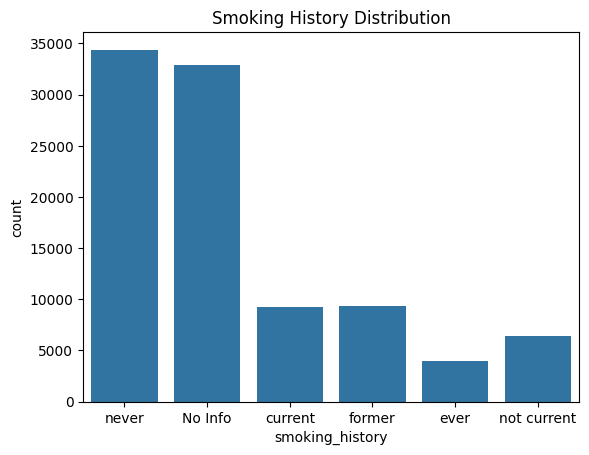

In [13]:
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

In [14]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67285
past_smoker    19664
current         9197
Name: count, dtype: int64


In [15]:
data = df.copy()

In [16]:
def perform_one_hot_encoding(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)
    return df

data = perform_one_hot_encoding(data, 'gender')
data = perform_one_hot_encoding(data, 'smoking_history')

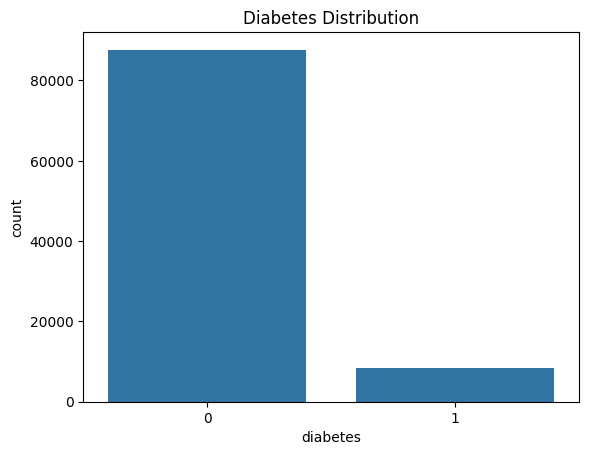

In [17]:
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [18]:
smote = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [19]:
# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [20]:
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('smote', smote),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [21]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [22]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


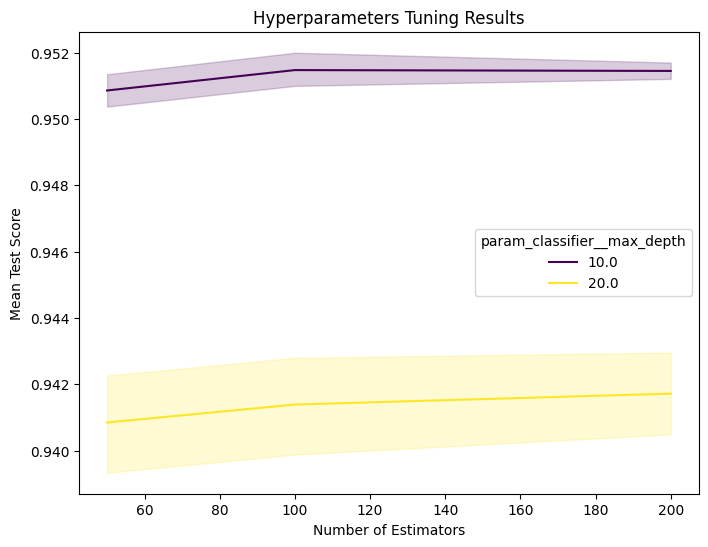

In [23]:
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

In [24]:
y_pred = grid_search.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Accuracy score: {:.2f}%'.format(score * 100))
print(classification_report(y_test, y_pred))

Accuracy score: 95.11%
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17509
           1       0.69      0.81      0.75      1721

    accuracy                           0.95     19230
   macro avg       0.84      0.89      0.86     19230
weighted avg       0.96      0.95      0.95     19230



                        Feature  Importance
2                   HbA1c_level    0.443883
3           blood_glucose_level    0.306941
0                           age    0.133498
1                           BMI    0.059172
4                  hypertension    0.025921
5                 heart_disease    0.018915
10   smoking_history_non-smoker    0.004015
11  smoking_history_past_smoker    0.003395
7                   gender_Male    0.001775
6                 gender_Female    0.001512
9       smoking_history_current    0.000968
8                  gender_Other    0.000004


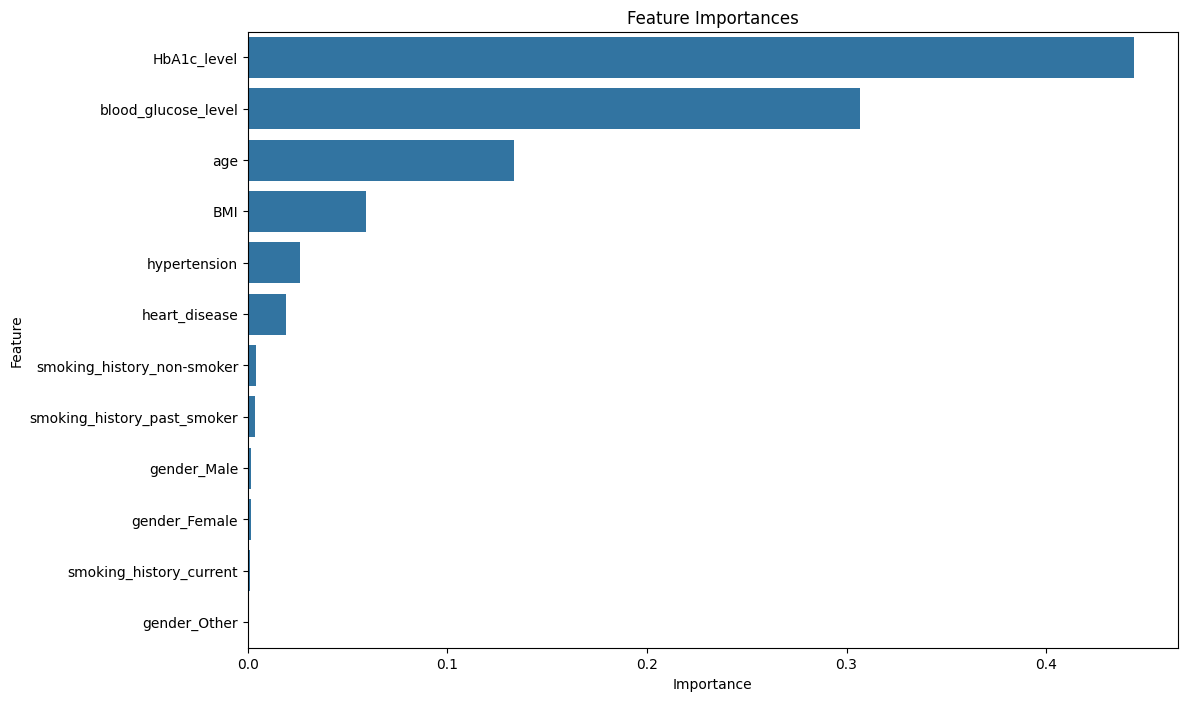

In [25]:
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()